In [1]:
import torch

from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor

from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv

from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

from torchrl.objectives import ClipPPOLoss, ValueEstimators

torch.manual_seed(911)
from tqdm import tqdm

In [2]:
params = {
    "CPPO": {
        "policy": {"share_params": True, "centralised": True},
        "critic": {"share_params": True, "centralised": True},
    },
    "MAPPO": {
        "policy": {"share_params": True, "centralised": False},
        "critic": {"share_params": True, "centralised": True},
    },
    "IPPO": {
        "policy": {"share_params": True, "centralised": False},
        "critic": {"share_params": True, "centralised": False},
    },
    "HetIPPO": {
        "policy": {"share_params": False, "centralised": False},
        "critic": {"share_params": False, "centralised": False},
    },
}

In [3]:
model_name = "MAPPO"

policy_params = params[model_name]["policy"]
critic_params = params[model_name]["critic"]

In [4]:
device = torch.device("cpu")
vmas_device = device

frames_per_batch = 6_000
n_iters = 400
total_frames = frames_per_batch * n_iters

num_epochs = 10
minibatch_size = 400
lr = 3e-4
max_grad_norm = 0.5

clip_epsilon = 0.2
gamma = 0.99
lmbda = 0.99
entropy_eps = 1e-3
critic_coef = 1
loss_critic_type = "smooth_l1"

In [5]:
max_steps = 200
num_vmas_envs = frames_per_batch // max_steps
print("num_vmas_envs =", num_vmas_envs)
scenario_name = "navigation"

env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,
    max_steps=max_steps,
    device=vmas_device,
)

num_vmas_envs = 30


In [6]:
print("action_spec:\n", env.full_action_spec, "\n")
print("reward_spec:\n", env.full_reward_spec, "\n")
print("done_spec:\n", env.full_done_spec, "\n")
print("observation_spec:\n", env.observation_spec, "\n")

action_spec:
 Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([30, 4, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([30, 4, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([30, 4, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torch.Size([30, 4])),
    device=cpu,
    shape=torch.Size([30])) 

reward_spec:
 Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([30, 4, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([30, 4, 1]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([30, 4, 1]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32

In [7]:
print("action_keys:", env.action_keys)
print("reward_keys:", env.reward_keys)
print("done_keys:", env.done_keys)

action_keys: [('agents', 'action')]
reward_keys: [('agents', 'reward')]
done_keys: ['done', 'terminated']


In [8]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

In [9]:
policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
        n_agent_outputs=2 * env.action_spec.shape[-1],
        n_agents=env.n_agents,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
        share_params=policy_params["share_params"],
        centralized=policy_params["centralised"],
        # layer_class=NoisyLinear, #doesn't work
    ),
    NormalParamExtractor(),
)

In [10]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)

In [11]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.unbatched_action_spec,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.unbatched_action_spec[env.action_key].space.low,
        "high": env.unbatched_action_spec[env.action_key].space.high,
    },
    return_log_prob=True,
    log_prob_key=("agents", "sample_log_prob"),
)

In [12]:
critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
    n_agent_outputs=1,
    n_agents=env.n_agents,
    device=device,
    depth=2,
    num_cells=256,
    activation_class=torch.nn.Tanh,
    share_params=critic_params["share_params"],
    centralized=critic_params["centralised"],
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "state_value")],
)

In [13]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

In [14]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,
)

In [15]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    critic_coef=critic_coef,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,
    entropy_bonus=True,
)
loss_module.set_keys(
    reward=env.reward_key,
    action=env.action_key,
    sample_log_prob=("agents", "sample_log_prob"),
    value=("agents", "state_value"),
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)


loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
)
GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

In [16]:
from torch.utils.tensorboard import SummaryWriter

In [17]:
tb_name = f"{model_name}_navigation_200steps"
writer = SummaryWriter(f"logs/{tb_name}")

In [ ]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

for iter, tensordict_data in enumerate(collector):
    # expand done, terminated flags for GAE in torchrl
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )

    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )

    data_view = tensordict_data.reshape(-1)
    replay_buffer.extend(data_view)

    for num_epoch in range(num_epochs):
        for num_batch in range(frames_per_batch // minibatch_size):
            num_grad_step = iter * num_epochs * (frames_per_batch // minibatch_size) + num_epoch * (frames_per_batch // minibatch_size) + num_batch

            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            writer.add_scalar(f"{tb_name}/mean_adv", subdata["advantage"].mean().item(), num_grad_step)
            writer.add_scalar(f"{tb_name}/loss_obj", loss_vals["loss_objective"].item(), num_grad_step)
            writer.add_scalar(f"{tb_name}/loss_critic", loss_vals["loss_critic"].item(), num_grad_step)
            writer.add_scalar(f"{tb_name}/loss_entropy", loss_vals["loss_entropy"].item(), num_grad_step)
            writer.add_scalar(f"{tb_name}/loss_total", loss_value.item(), num_grad_step)

            loss_value.backward()

            grad_norm = torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )

            writer.add_scalar(f"{tb_name}/grad_norm", grad_norm, num_grad_step)

            optim.step()
            optim.zero_grad()

    collector.update_policy_weights_()

    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    writer.add_scalar(f"{tb_name}/ep_rew_mean", episode_reward_mean, iter)

    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

In [19]:
from PIL import Image as PIL_Image
from IPython.display import Image as IPython_Image

In [22]:
def rendering_callback(env, td):
    env.frames.append(PIL_Image.fromarray(env.render(mode="rgb_array")))
env.frames = []


with torch.no_grad():
   env.rollout(
       max_steps=max_steps,
       policy=policy,
       callback=rendering_callback,
       auto_cast_to_device=True,
       break_when_any_done=False,
   )

env.frames[0].save(
    f"{scenario_name}.gif",
    save_all=True,
    append_images=env.frames[1:],
   duration=3,
   loop=0,
)

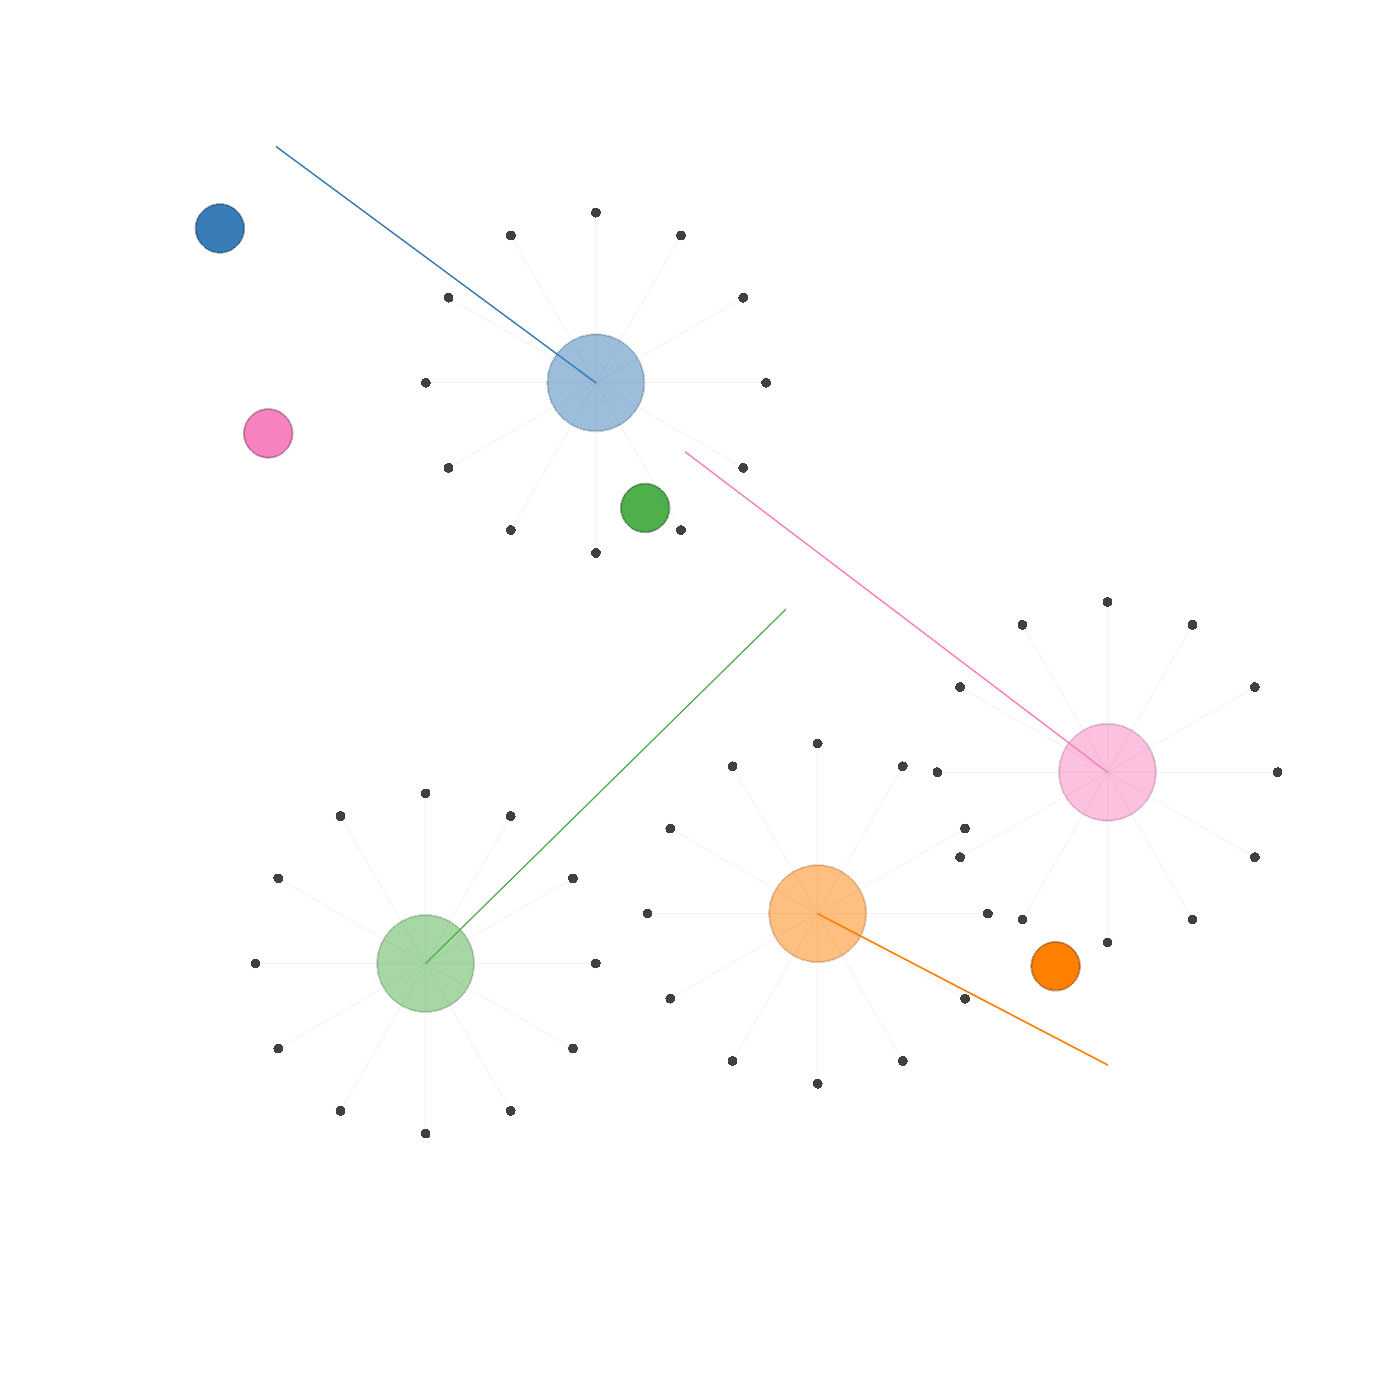

In [23]:
IPython_Image(open(f"{scenario_name}.gif", "rb").read())